In [1]:
import os
import sys

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
import nibabel as nib
import pickle
from importlib import reload
import h5py

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


'/home/rfpred'

In [2]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict, nsd_R2_dict, rsquare_selection, make_gaussian_2d
from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots, univariate_regression, multivariate_regression
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows, cap_values, _sort_by_column
# from funcs.viscontrasts import lgn_statistics
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

In [16]:
# doens't really work
# def reload():
import importlib
import funcs.imgproc
import funcs.rf_tools
import funcs.utility
import funcs.analyses
import notebooks.alien_nbs.lgnpy.lgnpy.CEandSC

# Reload the modules
importlib.reload(funcs.imgproc)
importlib.reload(funcs.rf_tools)
importlib.reload(funcs.utility)
importlib.reload(funcs.analyses)
importlib.reload(notebooks.alien_nbs.lgnpy.lgnpy.CEandSC)

# Re-import the functions
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots, univariate_regression, multivariate_regression
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows, cap_values, _sort_by_column
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

In [4]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

In [6]:
# print(vismask_dict[subject]['V1_mask'].astype('bool'))
subject = 'subj01'
mask_viscortex = np.zeros((vismask_dict[subject]['V1_mask'].shape))
distinct_roi_colours = 'y'
for roi_factor, roi in enumerate(vismask_dict[subject].keys()):
    if distinct_roi_colours == 'n':
        roi_facor = 1
        
    # mask_viscortex += (cap_values(vismask_dict[subject][roi],1000) * ((roi_factor + 1)**2))
    mask_viscortex += (cap_values(vismask_dict[subject][roi],1000) * ((roi_factor + 1)))


mask_v1 = vismask_dict[subject]['V1_mask']
prf_par = 'angle'

mask_flat = numpy2coords(mask_viscortex)

brain = cap_values(np.nan_to_num(prf_dict[subject]['nsd_dat'][prf_par]['prf_ar']),4)
brain_flat = numpy2coords(brain, keep_vals = True)

comrows = find_common_rows(brain_flat, mask_flat, keep_vals = True)


# slice_flt = cap_values(coords2numpy(coordinates = comrows, shape = brain.shape, keep_vals = True), threshold = 4)
slice_flt = coords2numpy(coordinates = comrows, shape = brain.shape, keep_vals = True)

im = plt.imshow(slice_flt[:,:100,78], cmap = 'inferno')
plt.colorbar(im)
plt.axis('off')
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

(-0.5, 185.5, 144.5, -0.5)

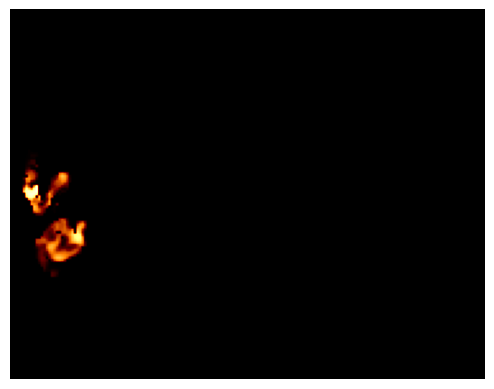

In [4]:
# plt.imshow(R2_dict['subj01']['full_R2']['R2_ar'][:,:,77], cmap = 'afmhot')
R2_dict = nsd_R2_dict(vismask_dict)

R2_dict['subj01']['full_R2']['R2_ar']
plt.imshow(coords2numpy(R2_dict['subj01']['R2_roi']['V1_mask'], shape = R2_dict['subj01']['full_R2']['R2_ar'].shape,keep_vals = True)[:,:,77], cmap = 'afmhot')
plt.axis('off')

In [5]:
R2_dict['subj01']['R2_roi']['V1_mask']
# 55, 11, 75
R2_dict['subj01']['full_R2']['R2_ar'][55,11,75]

1.163466453552246

In [5]:
import ipywidgets as widgets
from IPython.display import display

def viscortex_plot(prf_dict, vismask_dict, plot_param, subject, distinct_roi_colours:bool = True, inv_colour:bool = False, cmap = 'hot',
                   lowcap = None, upcap = None):

    mask_viscortex = np.zeros((vismask_dict[subject]['V1_mask'].shape))
    
    # Loop over all rois to create a mask of them conjoined
    for roi_factor, roi in enumerate(vismask_dict[subject].keys()):
        if distinct_roi_colours:
            roi_facor = 1
        mask_viscortex += (cap_values(vismask_dict[subject][roi], lower_threshold = lowcap, upper_threshold = upcap) * ((roi_factor + 1)))

    mask_flat = numpy2coords(mask_viscortex, keep_vals = True)

    if plot_param == 'nsdR2':
        R2_dict = nsd_R2_dict(vismask_dict)
        brain = cap_values(np.nan_to_num(R2_dict[subject]['full_R2']['R2_ar']), lower_threshold = lowcap, upper_threshold = upcap)
    else:
        brain = cap_values(np.nan_to_num(prf_dict[subject]['nsd_dat'][plot_param]['prf_ar']), lower_threshold = lowcap, upper_threshold = upcap)
    brain_flat = numpy2coords(brain, keep_vals = True)

    comrows = find_common_rows(brain_flat, mask_flat, keep_vals = True)

    # slice_flt = cap_values(coords2numpy(coordinates = comrows, shape = brain.shape, keep_vals = True), threshold = 4)
    slice_flt = coords2numpy(coordinates = comrows, shape = brain.shape, keep_vals = True)

    # Create sliders for each dimension
    z_slider = widgets.IntSlider(min=0, max=slice_flt.shape[2]-1, description='saggital')
    x_slider = widgets.IntSlider(min=0, max=slice_flt.shape[0]-1, description='horizontal:')
    # y_slider = widgets.IntSlider(min=0, max=slice_flt.shape[1]-1, description='coronal')
    y_slider = widgets.IntSlider(min=6, max=40, description='coronal')

    if inv_colour:
        rev = '_r'
    else:
        rev = ''

    # Function to update the plot
    def _update_plot(x, y, z):
        # Create a new figure with 2 subplots
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # Adjust the size as needed

        # Plot the first image on the left subplot
        img1 = np.rot90(mask_viscortex[:x, y, :z])
        im1 = axs[0].imshow(img1, cmap=f'{cmap}{rev}', vmin=np.min(mask_viscortex), vmax=np.max(mask_viscortex))
        axs[0].axis('off')
        cbar1 = fig.colorbar(im1, ax=axs[0])
        cbar1.set_ticks([1,2,3,4])  # Set tick positions
        cbar1.set_ticklabels(['V1', 'V2', 'V3', 'V4'])  # Set tick labels

        # Plot the second image on the right subplot
        img2 = np.rot90(slice_flt[:x, y, :z])
        im2 = axs[1].imshow(img2, cmap=f'{cmap}{rev}', vmin=np.min(brain), vmax=np.max(brain))
        axs[1].set_title(f'{plot_param} across visual cortex')
        axs[1].axis('off')
        fig.colorbar(im2, ax=axs[1])

        plt.show()
        
    widgets.interact(_update_plot, x=slice_flt.shape[0]-1, y=y_slider, z=slice_flt.shape[2]-1)
    
viscortex_plot(prf_dict = prf_dict, vismask_dict = vismask_dict, plot_param = 'size', subject = 'subj08', upcap = 1, lowcap = 0, inv_colour = False, cmap = 'gist_stern')

interactive(children=(IntSlider(value=142, description='x', max=426, min=-142), IntSlider(value=6, description…

In [ ]:
prf_dict.keys()

In [12]:
# Expand this function, based on how fast it can be, perhaps also include the valid docs I mention in OneNote.
def top_voxels(, input_dict = None, top_n = 1000, dataset = 'prf'):
    prf_pars = list(prf_dict['subj01']['proc']['V1_mask'].keys())[:-1]
    subjects = list(prf_dict.keys())
    
    rsq_dict = {}
    
    if dataset == 'prf':
        rois = input_dict['subj01']['proc'].keys()
    elif dataset == 'nsd':
        rois = input_dict['subj01']['R2_roi'].keys()

    for subject in subjects:
        subj_rsq = {}
        for roi in rois:
            if dataset == 'prf':
                rsq_ar = input_dict[subject]['proc'][roi]['R2']
                
            elif dataset == 'nsd':
                rsq_ar = input_dict[subject]['R2_roi'][roi]
                
            rsq_sort = np.argsort(rsq_ar[:, -1])
            rsq_top = rsq_ar[rsq_sort[-top_n:]]
            subj_rsq[roi] = rsq_top
            
        rsq_dict[subject] = subj_rsq
    return rsq_dict

SyntaxError: invalid syntax (2735467512.py, line 2)

In [5]:
 # This is basically what is also present inside the get_mask function, but now it just gives you a list of voxels       
def find_top_vox(subject = 'subj01', roi = 'V1', n_voxels = None, prf_dict = None, vismask_dict = None):
    roi_voxels = numpy2coords(vismask_dict[subject][f'{roi}_mask'], keep_vals = False)
    prf_pars = (list(prf_dict['subj01']['proc']['V1_mask'].keys())[:-1])
    R2_dict = nsd_R2_dict(vismask_dict)
    brain_shape = vismask_dict[subject][f'{roi}_mask'].shape

    if n_voxels == None or n_voxels == 'all':
        max_voxels = np.sum(vismask_dict[subject][f'{roi}_mask'])
    else: max_voxels = n_voxels

    top_vox_dict = {}
    voxel_count = 0
    for n_vox, these_coords in enumerate(roi_voxels):
        these_coords = list(these_coords)
        voxel_pars = {}
        voxel_pars['xyz'] = these_coords
        voxel_pars['roi'] = roi
        for prf_par in prf_pars:
            prf_par_vals = prf_dict[subject]['nsd_dat'][prf_par]['prf_ar'][these_coords[0], these_coords[1], these_coords[2]]
            voxel_pars[prf_par] = prf_par_vals
        # Also add the NSD Rsquared value to the dict.
        voxel_pars['nsdR2'] = R2_dict[subject]['full_R2']['R2_ar'][these_coords[0], these_coords[1], these_coords[2]]
        
        # Check if the voxel parameters meet the conditions
        if (0 <= voxel_pars['eccentricity']+(voxel_pars['size']/2) <= 1 and
            .3 <= voxel_pars['size'] <= 1 and
            0 <= voxel_pars['R2'] and
            25 <= voxel_pars['nsdR2']):
            top_vox_dict[f'voxel{voxel_count}'] = voxel_pars
            voxel_count += 1
            if voxel_count >= max_voxels:  # Stop after finding 10 voxels
                break


    print(f'Found {voxel_count} voxels in {roi}')
    return top_vox_dict

In [6]:
topvoxels = find_top_vox(subject = 'subj01',roi = 'V2', n_voxels = 'all', prf_dict = prf_dict, vismask_dict = vismask_dict)

topvoxels
# topvoxels['voxel0']

Found 6 voxels in V2


{'voxel0': {'xyz': [54, 21, 61],
  'roi': 'V2',
  'angle': 75.5415267944336,
  'eccentricity': 0.6557552814483643,
  'exponent': 0.09722618758678436,
  'gain': 0.7777680158615112,
  'meanvol': 601.6583251953125,
  'R2': 64.72003173828125,
  'size': 0.34625130891799927,
  'nsdR2': 29.433338165283203},
 'voxel1': {'xyz': [100, 24, 82],
  'roi': 'V2',
  'angle': 233.2727508544922,
  'eccentricity': 0.6770132184028625,
  'exponent': 0.04048101231455803,
  'gain': 0.6980307698249817,
  'meanvol': 581.2053833007812,
  'R2': 55.13924789428711,
  'size': 0.30321988463401794,
  'nsdR2': 29.2231388092041},
 'voxel2': {'xyz': [100, 24, 83],
  'roi': 'V2',
  'angle': 245.0668487548828,
  'eccentricity': 0.6201316714286804,
  'exponent': 0.007486667949706316,
  'gain': 0.7928726077079773,
  'meanvol': 562.7115478515625,
  'R2': 58.03012466430664,
  'size': 0.32681310176849365,
  'nsdR2': 25.82582664489746},
 'voxel3': {'xyz': [101, 25, 82],
  'roi': 'V2',
  'angle': 226.0159454345703,
  'eccentrici

In [7]:
def plot_this_vox(dim = 425, vox_dict_item = None, type:str = None, add_central_patch:bool = False, 
                  outline_rad = 1):
    
    # Get the coordinate indices of the voxel
    x_vox, y_vox, z_vox = [vox_dict_item['xyz'][i] for i in range(3)]
    prf_size = vox_dict_item['size']
    prf_angle = vox_dict_item['angle']
    prf_ecc = vox_dict_item['eccentricity']
    prf_expt = vox_dict_item['exponent']
    prf_gain = vox_dict_item['gain']
    prf_rsq = vox_dict_item['R2']
    nsdR2 = vox_dict_item['nsdR2']
    prf_meanvol = vox_dict_item['meanvol']
    roi = vox_dict_item['roi']
    
    # Calculate the radius
    sigma = prf_size * np.sqrt(prf_expt)
    sigma_pure = sigma * (dim / 8.4)
    
    # Get the 2d coordinates of the pRF
    y = ((1 + dim) / 2) - (prf_ecc * np.sin(np.radians(prf_angle)) * (dim / 8.4)) #y in pix (c_index)
    x = ((1 + dim) / 2) + (prf_ecc * np.cos(np.radians(prf_angle)) * (dim / 8.4)) #x in pix (r_index)

    if type == 'circle' or type == 'gaussian':
        deg_radius = sigma
        pix_radius = sigma_pure
    elif type == 'cut_gaussian' or type == 'full_gaussian' or type == 'outline':
        deg_radius = prf_size
        pix_radius = prf_size * (dim / 8.4)


    # Note: all the masks are made using pixel values for x, y, and sigma
    # Check whether the same is done later on, in the heatmaps and get_img_prf.
    if type == 'gaussian':
        prf_mask = make_gaussian_2d(dim, x, y, sigma_pure)
    elif type == 'circle':
        prf_mask = make_circle_mask(dim, x, y, sigma_pure)
    elif type == 'full_gaussian':
        prf_mask = make_gaussian_2d(dim, x, y, prf_size * (dim / 8.4))
    elif type == 'cut_gaussian':
        prf_mask = css_gaussian_cut(dim, x, y, prf_size * (dim / 8.4))
    else:
        raise ValueError(f"Invalid type: {type}. Available mask types are 'gaussian','circle','full_gaussian','cut_gaussian'.")
    
    central_patch = 0
    if add_central_patch:
        central_patch = make_circle_mask(dim, ((dim+2)/2), ((dim+2)/2), outline_rad * (dim / 8.4), fill = 'n')

    # Convert pixel indices to degrees of visual angle
    degrees_per_pixel = 8.4 / dim
    x_deg = (x - ((dim + 2) / 2)) * degrees_per_pixel
    y_deg = (((dim + 2) / 2) - y) * degrees_per_pixel
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow((prf_mask + central_patch), cmap='bone', origin='upper', extent=[-4.2, 4.2, -4.2, 4.2])
    ax.set_title(f'Region Of Interest: {roi}\n'
                f'Voxel: [{x_vox}, {y_vox}, {z_vox}]\n'
                f'pRF x,y,σ: {round(x_deg, 1), round(y_deg, 1), round(deg_radius, 1)}\n'
                f'Angle: {round(prf_angle, 2)}°\nEccentricity: {round(prf_ecc, 2)}°\n'
                f'Exponent: {round(prf_expt, 2)}\nSize: {round(prf_size, 2)}°\n'
                f'Explained pRF variance (R2): {round(prf_rsq, 2)}%\n'
                f'NSD R-squared: {round(nsdR2, 2)}%\n'
                f'pRF R-squared: {round(prf_rsq, 2)}%\n'
                f'pRF Gain: {round((prf_gain / prf_meanvol) *100, 2)}% BOLD\n')
    ax.set_xlabel('Horizontal Degrees of Visual Angle')
    ax.set_ylabel('Vertical Degrees of Visual Angle')

    # Set ticks at every 0.1 step
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

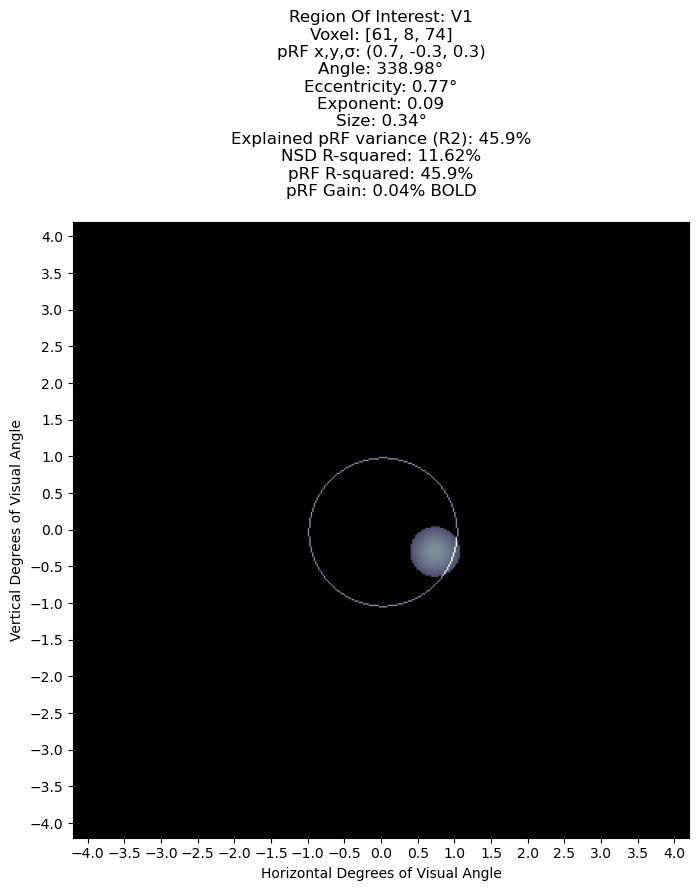

In [12]:
numbo = 0
numbo += 1
plot_this_vox(dim = 425, vox_dict_item = topvoxels[f'voxel{numbo}'], type = 'cut_gaussian', add_central_patch = True, outline_rad = 1)

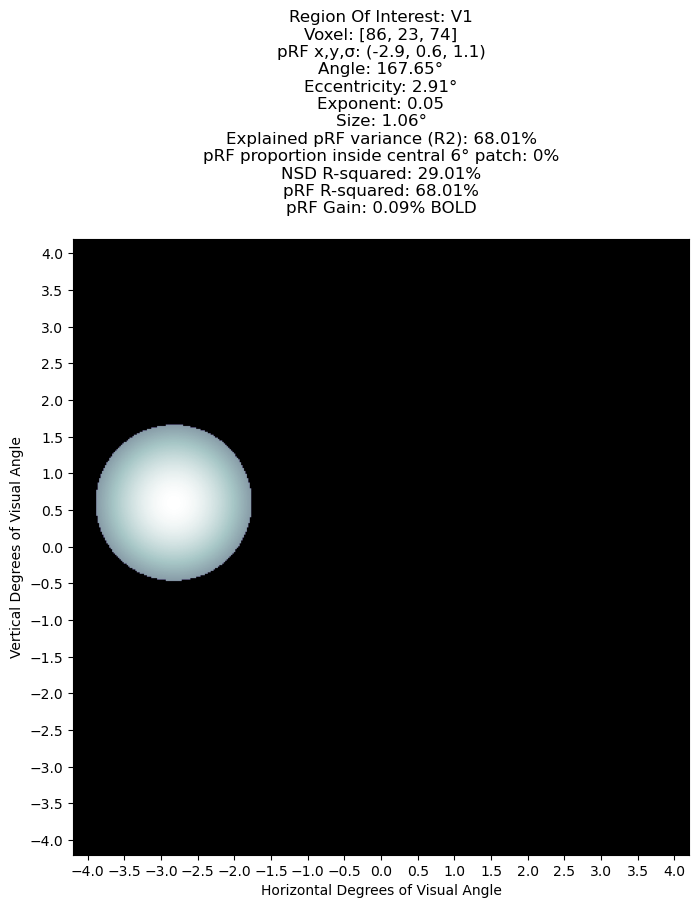

In [92]:
prf_info = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='cut_gaussian', roi='V1',
                                        plot = 'y', excl_reason = 'n', sigma_min=.1, sigma_max = 2,
                                        ecc_min = 0, ecc_max = 3,
                                        angle_min = 0, angle_max = 360, nsdR2_min = 20)


In [8]:
# Load in the original RMS dict (where RMS is calculated before cropping)
with open('./data/custom_files/all_visfeats_rms.pkl', 'rb') as fp:
   visfeats_rms = pickle.load(fp)
   
# Load in the new RMS dict (where RMS is calculated after cropping, thus cropping prior to RMS)
with open('./data/custom_files/all_visfeats_rms_crop_prior.pkl', 'rb') as fp:
   visfeats_rms_crop_prior = pickle.load(fp)
   
# Load in the Spatial Coherence and Contrast Energy dictionary (this is still where for both the pooling range was 1 degree visual angle)
with open('/home/rfpred/data/custom_files/all_visfeats_scce.pkl', 'rb') as fp:
    visfeats_scce = pickle.load(fp)
    
# Load in the Spatial Coherence and Contrast Energy dictionary (here the pooling range was 2.8 degrees of visual angle, so only look at SC)
with open('/home/rfpred/data/custom_files/all_visfeats_scce_large.pkl', 'rb') as fp:
    visfeats_scce_large = pickle.load(fp)
    
# Load in the .h5 file containing the predictability estimates for subject 01
with h5py.File('/home/rfpred/data/custom_files/subj01/pred/all_predestims.h5', 'r') as hf:
    data = hf.keys()
    predfeats = {key: np.array(hf[key]).flatten() for key in data}

In [9]:
# Load in the saved masks for selected voxels that have their prf inside the inner patch.
with open('./data/custom_files/subj01/prf_mask_center_strict.pkl', 'rb') as fp:
    prf_mask_center_strict = pickle.load(fp)
    
# Load in the saved masks for voxels with pRF inside central 1.25 degrees patch
with open('./data/custom_files/subj01/prf_mask_central_strict_l.pkl', 'rb') as fp:
   prf_mask_center_strict_l = pickle.load(fp)    

# Load in the saved masks for voxels with pRF loosely (at least 50%) inside central 1 degrees patch
with open('./data/custom_files/subj01/prf_mask_central_halfloose.pkl', 'rb') as fp:
   prf_mask_central_halfloose = pickle.load(fp)    

# Load in the saved masks for voxels with pRFs that have their center inside the central 1 degree patch
with open('./data/custom_files/subj01/prf_mask_central_loose.pkl', 'rb') as fp:
    prf_mask_central_loose = pickle.load(fp) 

# Load in the saved masks that have their pRFs exclusively outside the central 1 degree patch
with open('./data/custom_files/subj01/prf_mask_periphery_strict.pkl', 'rb') as fp:
   prf_mask_periphery_strict = pickle.load(fp)
  
  
# THESE ARE TOO SCARCE, ALMOST NO VOXELS ARE LEFT OVER 
# # Load in the prf-based rsquared selections
# with open('/home/rfpred/data/custom_files/subj01/prf_mask_center_strict_prf_rsq.pkl', 'rb') as fp:
#    prf_mask_center_strict_prf_rsq = pickle.load(fp)   

# # Load in the prf-based rsquared selections
# with open('/home/rfpred/data/custom_files/subj01/prf_mask_center_strict_nsd_rsq.pkl', 'rb') as fp:
#    prf_mask_center_strict_nsd_rsq = pickle.load(fp)   

In [10]:
R2_dict = nsd_R2_dict(vismask_dict)



prf_rsq_dict = rsquare_selection(prf_dict, 1000, n_subjects = n_subjects, dataset = 'prf')
prf_rsq_dict_mapped = coords2numpy(prf_rsq_dict['subj01']['V1_mask'], shape = vismask_dict['subj01']['V1_mask'].shape, keep_vals = True)
nsd_rsq_dict = rsquare_selection(R2_dict, 1000, n_subjects = n_subjects, dataset = 'nsd')

[[67.       6.      68.      28.19995]
 [74.      13.      83.      28.2006 ]
 [67.      10.      72.      28.21646]
 ...
 [69.      10.      77.      46.42923]
 [71.      10.      77.      46.42925]
 [70.      10.      77.      48.11262]]
[[ 55.        7.       77.        3.61605]
 [ 55.       11.       75.       11.14883]
 [ 56.        7.       76.        2.09502]
 ...
 [106.       20.       80.        5.85023]
 [107.       18.       80.      -20.66737]
 [107.       19.       80.        1.99449]]
(145, 186, 148)


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


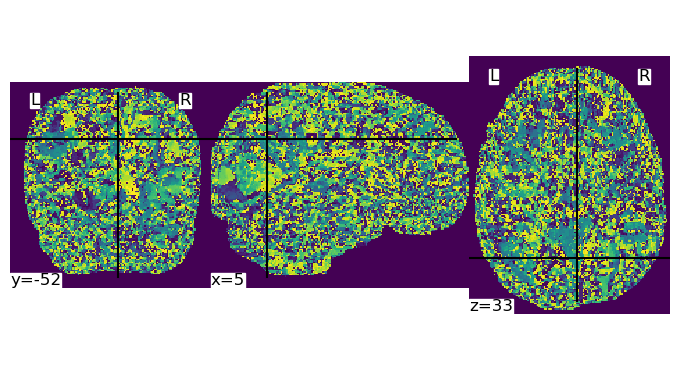

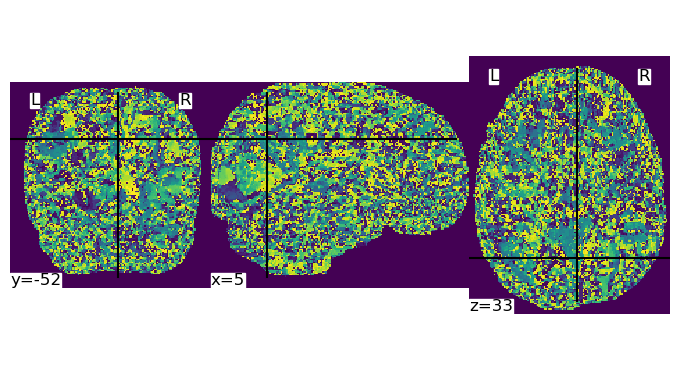

In [11]:
import mne
print(nsd_rsq_dict['subj01']['V1_mask'])


print (prf_dict['subj01']['proc']['V1_mask']['R2'])

print(prf_dict['subj01']['nsd_dat']['angle']['prf_ar'].shape)


from nilearn import plotting
import nibabel as nib

# Load the NIfTI image
# img = nib.load('path_to_your_nifti_file.nii.gz')
img = prf_dict['subj01']['nsd_dat']['angle']['prf_dat']

# Plot the NIfTI image
plotting.plot_img(img)
plotting.show()

# Get the image data as a numpy array
data = img.get_fdata()

# Replace NaN values with zeros
data = np.nan_to_num(data)

# Create a new NIfTI image with the modified data
new_img = nib.Nifti1Image(data, img.affine, img.header)

# Now you can use new_img in place of img

# Plot the NIfTI image
plotting.plot_img(new_img)
plotting.show()

beta_dict0_2.pkl
	Amount of voxels in V1: 316
	Amount of voxels in V2: 609
	Amount of voxels in V3: 609
	Amount of voxels in V4: 480
	Processed images: 2250
beta_dict3_5.pkl
	Amount of voxels in V1: 316
	Amount of voxels in V2: 609
	Amount of voxels in V3: 609
	Amount of voxels in V4: 480
	Processed images: 4500
beta_dict6_10.pkl
	Amount of voxels in V1: 316
	Amount of voxels in V2: 609
	Amount of voxels in V3: 609
	Amount of voxels in V4: 480
	Processed images: 8250
beta_dict11_15.pkl
	Amount of voxels in V1: 316
	Amount of voxels in V2: 609
	Amount of voxels in V3: 609
	Amount of voxels in V4: 480
	Processed images: 12000
beta_dict16_20.pkl
	Amount of voxels in V1: 316
	Amount of voxels in V2: 609
	Amount of voxels in V3: 609
	Amount of voxels in V4: 480
	Processed images: 15750
beta_dict21_27.pkl
	Amount of voxels in V1: 316
	Amount of voxels in V2: 609
	Amount of voxels in V3: 609
	Amount of voxels in V4: 480
	Processed images: 21000
beta_dict28_35.pkl
	Amount of voxels in V1: 316


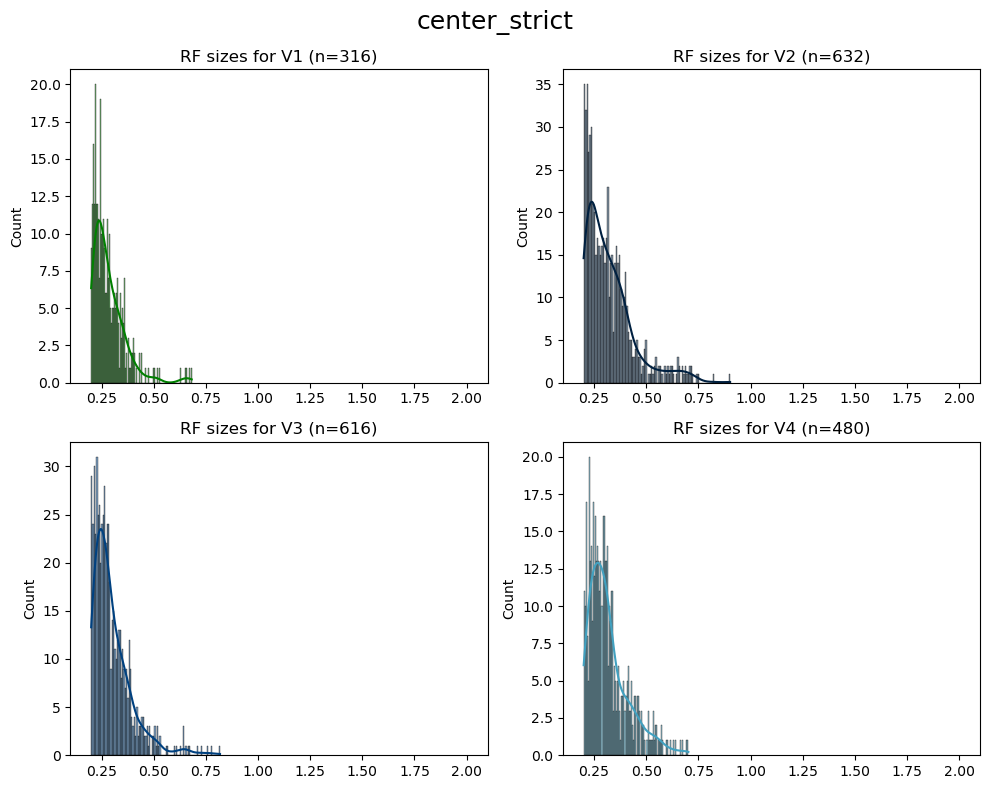

In [17]:
# 1 min
# hrf_dict_tight, voxmask_tight, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
#                                              min_size = .25, max_size = 1, prf_proc_dict = prf_dict, vox_n_cutoff = 150,plot_sizes = 'y')

hrf_dict_tight, voxmask_tight, joint_voxs, sizes, bsesh  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
                                             min_size = .2, max_size = 2, prf_proc_dict = prf_dict, vox_n_cutoff = None ,plot_sizes = 'y')



In [44]:
import numpy as np
import nibabel as nib
import pickle
import os

def get_betas(subjects, voxels, start_session, end_session, prf_region='center'):
    beta_dict = {}
    
    if subjects == 'all':
        subjects = [f'subj{i:02d}' for i in range(1, 9)]
    else:
        subjects = [subjects]
    
    for subject in subjects:
        beta_dict[subject] = {}
        rois = list(voxels[subject].keys())
        hrf_betas = {}
        
        for session in range(start_session, end_session + 1):
            session_str = f'{session:02d}'
            session_nifti = nib.load(f'/home/rfpred/data/natural-scenes-dataset/nsddata_betas/ppdata/{subject}/func1mm/betas_fithrf_GLMdenoise_RR/betas_session{session_str}.nii.gz').get_fdata(caching='unchanged')
            n_imgs = session_nifti.shape[3]
        
            print(f'Working on session: {session} of subject: {subject}')
            for roi in rois:
                if session == start_session:
                    hrf_betas[roi] = {}
                
                voxel_mask = voxels[subject][roi]
                n_voxels = np.sum(voxel_mask).astype('int')
                vox_indices = np.zeros([n_voxels, voxel_mask.ndim], dtype=int)
                
                for coordinate in range(vox_indices.shape[1]):
                    vox_indices[:, coordinate] = np.where(voxel_mask == 1)[coordinate]
                
                for voxel in range(n_voxels):
                    vox_idx = tuple(vox_indices[voxel])
                    hrf_betas_ses = (np.array(session_nifti[vox_idx]).reshape(n_imgs, 1)) / 300
                    
                    if session == start_session:
                        hrf_betas[roi][f'voxel{voxel + 1}'] = {
                            'vox_idx': vox_idx,
                            'beta_values': hrf_betas_ses
                        }
                    else:
                        hrf_betas[roi][f'voxel{voxel + 1}']['beta_values'] = np.append(hrf_betas[roi][f'voxel{voxel + 1}']['beta_values'], hrf_betas_ses)
                    
            with open(f'./data/custom_files/{subject}/intermediate_hrf_save.pkl', 'wb') as fp:
                pickle.dump(hrf_betas, fp)
                print('     - Back-up saved to intermediate_hrf_save.pkl\n')
                    
        beta_dict[subject] = hrf_betas               
        
    with open(f'./data/custom_files/{subject}/beta_dict{start_session}_{end_session}_{prf_region}.pkl', 'wb') as fp:
        pickle.dump(beta_dict, fp)
        print(f'     - Back-up saved to beta_dict{start_session}_{end_session}_{prf_region}.pkl\n')        
        
    return beta_dict


In [46]:
test_betas_sub1 = get_betas('subj01', prf_mask_center_strict, 1, 2, prf_region = 'center_strict')


FileNotFoundError: No such file or no access: '/home/rfpred/data/natural-scenes-dataset/nsddata_betas/ppdata/subj01/func1mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz'

In [43]:

files = os.listdir(f'/home/rfpred/data/custom_files/subj01/center_strict/')

# Filter files that start with "beta_dict" and end with ".pkl"
filtered_files = [file for file in files if file.startswith("beta_dict") and file.endswith(".pkl")]

# Sort files based on the first number after 'beta_dict'
sorted_files = sorted(filtered_files, key=lambda x: int(''.join(filter(str.isdigit, x.split('beta_dict')[1]))))

# Print the sorted file names
for n_file, file_name in enumerate(sorted_files):
    print(file_name)
        
    with open(f'/home/rfpred/data/custom_files/subj01/center_strict/{file_name}', 'rb') as fp:
        beta_session = pickle.load(fp)
    
print_dict_structure(beta_session['subj01']['V1_mask']['voxel1'])

beta_dict0_2.pkl
beta_dict3_5.pkl
beta_dict6_10.pkl
beta_dict11_15.pkl
beta_dict16_20.pkl
beta_dict21_27.pkl
beta_dict28_35.pkl
beta_dict36_39.pkl


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [13]:

aaa = hrf_dict_tight['subj01']['V1_mask'][f'voxel1']['xyz'] == topvoxels['voxel1']['xyz']

topvoxels

{'voxel0': {'xyz': [54, 21, 61],
  'roi': 'V2',
  'angle': 75.5415267944336,
  'eccentricity': 0.6557552814483643,
  'exponent': 0.09722618758678436,
  'gain': 0.7777680158615112,
  'meanvol': 601.6583251953125,
  'R2': 64.72003173828125,
  'size': 0.34625130891799927,
  'nsdR2': 29.433338165283203},
 'voxel1': {'xyz': [100, 24, 82],
  'roi': 'V2',
  'angle': 233.2727508544922,
  'eccentricity': 0.6770132184028625,
  'exponent': 0.04048101231455803,
  'gain': 0.6980307698249817,
  'meanvol': 581.2053833007812,
  'R2': 55.13924789428711,
  'size': 0.30321988463401794,
  'nsdR2': 29.2231388092041},
 'voxel2': {'xyz': [100, 24, 83],
  'roi': 'V2',
  'angle': 245.0668487548828,
  'eccentricity': 0.6201316714286804,
  'exponent': 0.007486667949706316,
  'gain': 0.7928726077079773,
  'meanvol': 562.7115478515625,
  'R2': 58.03012466430664,
  'size': 0.32681310176849365,
  'nsdR2': 25.82582664489746},
 'voxel3': {'xyz': [101, 25, 82],
  'roi': 'V2',
  'angle': 226.0159454345703,
  'eccentrici

In [15]:
list(topvoxels['voxel1']['xyz'])
for i in range(1,5):
    a = (hrf_dict_tight['subj01']['V1_mask'][f'voxel{i}']['xyz'])
    print(a)
    
    
# list(hrf_dict_tight['subj01']['V1_mask'].keys())
len(hrf_dict_tight['subj01']['V4_mask'].keys())

print(len(hrf_dict_tight['subj01']['V1_mask']['voxel425']))
print(hrf_dict_tight['subj01']['V1_mask']['voxel425'])

[56, 9, 74]
[56, 9, 77]
[56, 10, 75]
[56, 13, 69]
2250
[-0.57    -0.78333  0.22333 ...  3.17333  2.19    -1.02333]


In [174]:
y = get_zscore(hrf_dict_tight['subj01']['V1_mask']['voxel1']['hrf_betas'])
this_vox = 1
n_voxels = len(list(hrf_dict_tight['subj01']['V1_mask'].keys()))
print(n_voxels)

for i in range(1, n_voxels-500):
# for i in range(1,5):
    
    xyz_beta = (hrf_dict_tight['subj01']['V1_mask'][f'voxel{i}']['xyz'])
    print(xyz_beta)
    # this_vox = f'voxel{vox}'
    # vox_info = hrf_dict_tight['subj01']['V1_mask'][this_vox]
    
    # topvoxels['voxel1']['xyz']

    


Original array: [-0.00333 -0.96    -1.20333 ... -0.82667  0.66667 -0.51333]
Z-scores: [ 0.02184 -0.83567 -1.05378 ... -0.71616  0.62239 -0.4353 ]
610
[56, 9, 74]
[56, 9, 77]
[56, 10, 75]
[56, 13, 69]
[56, 14, 69]
[56, 14, 70]
[57, 9, 74]
[57, 10, 72]
[57, 11, 76]
[57, 12, 62]
[57, 12, 69]
[57, 13, 64]
[57, 13, 65]
[57, 13, 66]
[57, 13, 68]
[57, 13, 69]
[57, 13, 70]
[57, 14, 65]
[57, 14, 67]
[57, 14, 68]
[57, 14, 69]
[57, 15, 63]
[57, 15, 64]
[57, 15, 69]
[58, 7, 75]
[58, 9, 72]
[58, 9, 73]
[58, 9, 75]
[58, 10, 71]
[58, 10, 72]
[58, 10, 74]
[58, 11, 62]
[58, 11, 68]
[58, 11, 69]
[58, 11, 70]
[58, 11, 71]
[58, 11, 72]
[58, 11, 73]
[58, 11, 74]
[58, 12, 62]
[58, 12, 65]
[58, 12, 66]
[58, 12, 67]
[58, 12, 68]
[58, 12, 69]
[58, 12, 70]
[58, 12, 71]
[58, 12, 72]
[58, 12, 73]
[58, 12, 74]
[58, 13, 61]
[58, 13, 62]
[58, 13, 63]
[58, 13, 64]
[58, 13, 65]
[58, 13, 66]
[58, 13, 67]
[58, 13, 68]
[58, 13, 69]
[58, 13, 70]
[58, 13, 71]
[58, 13, 74]
[58, 14, 61]
[58, 14, 62]
[58, 14, 63]
[58, 14, 64]

In [59]:
y = get_zscore(hrf_dict_tight['subj01']['V1_mask']['voxel1']['hrf_betas'])
this_vox = 1
voxel_keys = list(hrf_dict_tight['subj01']['V1_mask'].keys())
for vox in range(len(voxel_keys)):
    print(this_vox)
    match = np.array_equal(hrf_dict_tight['subj01']['V1_mask'][f'voxel{this_vox}']['xyz'], np.array(topvoxels['voxel1']['xyz']))
    while not match:
        this_vox += 1
        if this_vox > len(voxel_keys):
            break
        match = np.array_equal(hrf_dict_tight['subj01']['V1_mask'][f'voxel{this_vox}']['xyz'], np.array(topvoxels['voxel1']['xyz']))
    if match or this_vox > len(voxel_keys):
        break
print(this_vox)

Original array: [-0.00333 -0.96    -1.20333 ... -0.82667  0.66667 -0.51333]
Z-scores: [ 0.02184 -0.83567 -1.05378 ... -0.71616  0.62239 -0.4353 ]
1


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# prf_mask_center_strict['subj01']['V1_mask'].shape
prf_mask_center_strict_prf_rsq[0]['subj01']['V1_mask'].shape

In [ ]:
prfgain = prf_dict['subj01']['nsd_dat']['eccentricity']['prf_dat']
prfsok = prf_dict['subj01']['nsd_dat']['R2']['prf_dat']


print(prfgain.shape)

v1betas = hrf_dict_tight['subj01']['V1_mask']['roi_sizes'][:,:-1].astype('int')
# print(v1betas)
v1np = coords2numpy(v1betas, prfgain.shape)
    
    
v1nii = nib.Nifti1Image(v1np.astype(np.int16), affine=np.eye(4))

plotting.plot_stat_map(v1nii, display_mode = 'ortho')


In [ ]:
from nilearn import plotting
brain = vismask_dict['subj01']['V1_mask']

ni_img = nib.Nifti1Image(brain.astype(np.int16), affine=np.eye(4))
plotting.view_img(prfsok, display_mode = 'ortho')


# plotting.plot_roi(prfgain, display_mode='ortho', cut_coords=(12, 68, 60), title='V1 Mask')



In [ ]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image


In [ ]:
imgnp = show_stim(img_no = 46002, small = 'y')[0]
imgPIL = Image.fromarray(imgnp) # Convert into PIL from np
imgt = transform(imgPIL) # Transform into the right format for alexnet
img = imgt.unsqueeze(0) # add a batch dimension

#################################

In [ ]:
import torch.nn as nn

class AlexNetConv4(nn.Module):
    def __init__(self):
        super(AlexNetConv4, self).__init__()
        self.features = nn.Sequential(
            # stop at conv4
            *list(models.alexnet(pretrained=True).features.children())[:10]
        )
    def forward(self, x):
        x = self.features(x)
        return x

model = AlexNetConv4()
model.eval()

In [ ]:
# Perform the forward pass
with torch.no_grad():
    img_out = model(img)

#########################################################

In [ ]:
import torch
import torchvision.models as models

# Load the pretrained AlexNet model
model = models.alexnet(pretrained=True)
model.eval()  # Set the model to evaluation mode


In [ ]:
from torch.nn import Module

class AlexNetFeatureExtractor(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractor, self).__init__()
        # Assuming you want to capture outputs after each max pooling layer
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:3])  # Up to first max pooling
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[3:6])  # Up to second max pooling
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[6:8])  # Up to third max pooling
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[8:10])  # Up to fourth max pooling
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[10:13])  # Up to fifth max pooling

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        return x1, x2, x3, x4, x5


In [ ]:
from torch.nn import Module

class AlexNetFeatureExtractor(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractor, self).__init__()
        # Assuming you want to capture outputs after each max pooling layer
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:3])  # Up to first max pooling
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[3:6])  # Up to second max pooling
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[6:8])  # Up to third max pooling
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[8:10])  # Up to fourth max pooling
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[10:13])  # Up to fifth max pooling

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        return x1, x2, x3, x4, x5

feature_extractor = AlexNetFeatureExtractor(model)

#### This one works for the full 425x425 images

In [ ]:
from torchvision import transforms
from PIL import Image

# Load and preprocess the image
# img = Image.open('path_to_your_image.jpg')
img = imgPIL
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize so the smallest side is 256
    transforms.CenterCrop(227),  # Crop a 227x227 patch from the center
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension


#### This is for the 100x100 crops

In [ ]:
from torchvision import transforms
from PIL import Image

imgnp = show_stim(img_no = 1884, small = 'y')[0][163:263,163:263]
imgPIL = Image.fromarray(imgnp) # Convert into PIL from np
# imgt = transform(imgPIL) # Transform into the right format for alexnet
# img = imgt.unsqueeze(0) # add a batch dimension
# img = imgPIL
preprocess = transforms.Compose([
    transforms.Resize(227),  # Resize the image to 227x227 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(imgPIL).unsqueeze(0)  # Add batch dimension


In [ ]:
plt.imshow(imgnp)
plt.axis('off')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features(features, num_cols=5):
    # Choose a single layer output to visualize
    layer_features = features[0]  # For example, visualize the first layer outputs
    num_features = layer_features.shape[1]  # Number of channels in the selected layer

    num_rows = (num_features + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    
    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        if i < num_features:
            # Normalize feature map for better visualization
            feature_map = layer_features[0, i].detach().numpy()
            feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
            ax.imshow(feature_map, cmap='grey')
        ax.axis('off')

    plt.show()

# Assuming you have initialized and passed the image through the feature_extractor
features = feature_extractor(img_tensor)
plot_features(features)


#########################################

In [13]:
import torch
import torchvision.models as models

# Load the pretrained AlexNet model
alexnet = models.alexnet(pretrained=True)
alexnet.eval()


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

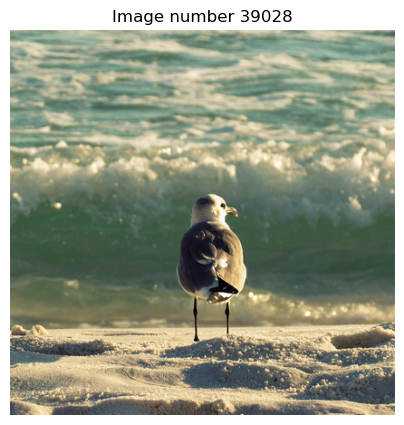

In [14]:
from torchvision import transforms
from PIL import Image

# Define the image transformation
preprocess = transforms.Compose([
    transforms.Resize(227),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your image
img = Image.fromarray(show_stim(small = 'y')[0])
img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension


In [15]:
from torch import nn

class AlexNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractor, self).__init__()
        self.features = model.features
        self.avgpool = model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# Initialize the feature extractor
feature_extractor = AlexNetFeatureExtractor(alexnet)

# Extract features
features = feature_extractor(img_tensor)


In [20]:
from funcs.imgproc import rand_img_list

n_imgs = 1000
imgs, _,_ = rand_img_list(n_imgs, asPIL = False, add_masks = False, select_ices = get_imgs_designmx()['subj01'][:n_imgs])



def get_alexnet_features(imgs):
    
    # Load your image
    # img = Image.fromarray(show_stim(small = 'y')[0])
    for n, img in enumerate(imgs):
        print(n)
        img = Image.fromarray(img[163:263,163:263])
        img_tensor = preprocess(img).unsqueeze(0) # Add batch dimension
        features = feature_extractor(img_tensor)
        print(features)
        if n == 0:
            all_feats = np.zeros((features.shape[1], len(imgs)))
        all_feats[:,n] = features.detach().numpy()
    return all_feats


In [21]:
ft = get_alexnet_features(imgs)

0
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
1
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1321]],
       grad_fn=<ViewBackward0>)
2
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
3
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0315, 1.2402, 1.2402]],
       grad_fn=<ViewBackward0>)
4
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
5
tensor([[ 0.0000,  0.0000,  0.0000,  ..., 11.4544, 14.8936, 14.8936]],
       grad_fn=<ViewBackward0>)
6
tensor([[0.0000, 0.4740, 0.4740,  ..., 0.0000, 0.0102, 0.1412]],
       grad_fn=<ViewBackward0>)
7
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
8
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
9
tensor([[0.0000, 0.0000, 0.0000,  ..., 2.0147, 2.1220, 2.1220]],
       grad_fn=<ViewBackward0>)
10
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
11
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
12
tensor([[0., 0., 0

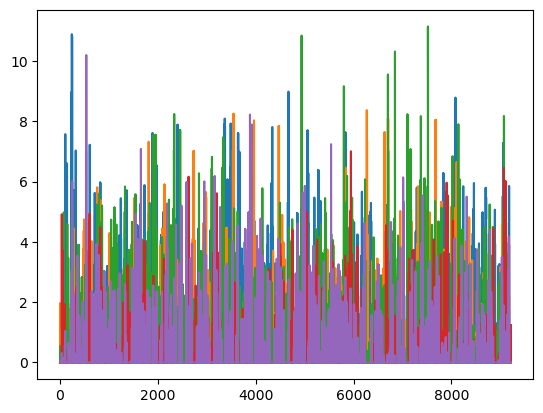

In [22]:
plt.plot(ft[:,0])
plt.plot(ft[:,1])
plt.plot(ft[:,2])
plt.plot(ft[:,3])
plt.plot(ft[:,4])

In [23]:
hrf_dict_tight['subj01']['V1_mask'].keys()

NameError: name 'hrf_dict_tight' is not defined

In [24]:
def get_beta_selection(subject = 'subj01', roi = 'V1_mask', n_voxels = 10, n_imgs = 100, hrf_dict = None):
    vox_ids = list(hrf_dict[subject][roi].keys())
    y = np.zeros((n_imgs, n_voxels))
    for vox in range(n_voxels):
        vox_id = vox_ids[vox]
        
        y[:,vox] = hrf_dict[subject][roi][vox_id]['hrf_betas'][:n_imgs]
        
        
    return y
# hrf_dict_tight['subj01']['V1_mask']['voxel1']['hrf_betas'].shape

bets = get_beta_selection(subject = 'subj01', roi = 'V1_mask', n_voxels = 5, n_imgs = 10000, hrf_dict = hrf_dict_tight)

NameError: name 'hrf_dict_tight' is not defined

In [ ]:
bets.shape

In [ ]:
if ft.shape[0] != n_imgs:
    ft = ft.T
ft.shape


In [ ]:
from sklearn.cross_decomposition import PLSRegression

# Assuming 'features' is a matrix of features from your images
# and 'betas' is a matrix of HRF betas from your fMRI dataset
pls = PLSRegression(n_components=40)
pls.fit(ft, bets)
# pls.fit(features.numpy(), betas)


# You can now use pls to predict, analyze coefficients, etc.


In [ ]:
coefficients = pls.coef_


In [ ]:
def calculate_vip(model):
    t = model.x_scores_  # Scores
    w = model.x_weights_  # Weights
    q = model.y_loadings_  # Loadings

    p, h = w.shape
    vips = np.zeros((p,))
    
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    
    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vips[i] = np.sqrt(p * (s.T @ weight) / total_s)
    
    return vips

vip_scores = calculate_vip(pls)
print(vip_scores)

In [ ]:
import matplotlib.pyplot as plt

# Plotting the scores
plt.figure(figsize=(10, 6))
plt.scatter(pls.x_scores_[:, 0], pls.x_scores_[:, 1], c='blue', label='PLS Scores')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Score Plot')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Cross-validation predictions
y_cv = cross_val_predict(pls, ft, bets, cv=5)

# Calculate metrics
mse = mean_squared_error(bets, y_cv)
r2 = r2_score(bets, y_cv)

print(f'MSE: {mse}')
print(f'R^2: {r2}')


In [ ]:
n_imgs = 10000
# start = n_imgs + random.randint(0,72999-n_imgs)
start = 15000
new_imgs, _,_ = rand_img_list(n_imgs, asPIL = False, add_masks = False, select_ices = get_imgs_designmx()[0]['subj01'][start:n_imgs+start])
# new_imgs = [Image.fromarray(sokje[163:263,163:263]) for sokje in new_imgs]
new_features = get_alexnet_features(new_imgs).T

In [ ]:
if new_features.shape[0] != n_imgs:
    new_features = new_features.T
new_features.shape
# Predicting new data (assuming 'new_features' is your new dataset)
new_betas_predicted = pls.predict(new_features)


In [ ]:
import matplotlib.pyplot as plt

# Example: Plotting the predicted beta values
plt.figure(figsize=(10, 10))
plt.plot(new_betas_predicted[100:175], 'ro-', label='Predicted Betas')
plt.plot(bets[100:175], 'bo-', label='Predicted Betas')
plt.title('Predicted HRF Betas from New Images')
plt.xlabel('Image Index')
plt.ylabel('Predicted Beta Value')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'actual_values' and 'predicted_values' are your datasets
actual_values = bets  # This should be your actual data
# predicted_values = pls.predict(features.numpy())  # Predict using your PLS model
predicted_values = pls.predict(new_features)
# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.title('Fit Plot for PLS Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plot a line of perfect fit
line = np.linspace(min(actual_values.min(), predicted_values.min()), max(actual_values.max(), predicted_values.max()), 100)
plt.plot(line, line, color='red', linewidth=2, linestyle='--', label='Perfect Fit')

plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'features' and 'betas' are your datasets
# X = features.numpy()  # Convert to numpy if not already
X = ft
Y = bets

# Lists to store the metrics
r2_scores = []
mse_scores = []
component_range = range(10, 25)  # Adjust the range based on your dataset and needs

for n_components in component_range:
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    Y_pred = pls.predict(X)
    
    # Calculate metrics
    r2 = r2_score(Y, Y_pred)
    mse = mean_squared_error(Y, Y_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(component_range, r2_scores, marker='o', linestyle='-', color='b')
plt.title('R² Score vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(component_range, mse_scores, marker='o', linestyle='-', color='r')
plt.title('MSE vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()
